# Homework 5

## PreProcess

**The importation library**

In [33]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from queue import Queue
import numpy as np

**Reading documents**

Set the graph with networkx.

In [34]:
graph = nx.DiGraph()
# for each link in links add edge
# the weight of edges is 1 (for all)
for line in open('wikigraph_reduced.csv', 'r').readlines()[1:]:
    nodes = line.replace('\n', '').split('\t')
    graph.add_edge(int(nodes[1]), int(nodes[2]), weight=1)

Set the category dictionary.

In [35]:
categories = dict()
#for each category set the name as key and a list of nodes as article
for line in open('wiki-topcats-categories.txt', 'r').readlines():
    s = line.index(':')
    e = line.index(';')
    cat_name = line[s+1 : e].replace('_', ' ')
    cat_list = line[e+1:].split()
    categories[cat_name] = [int(c) for c in cat_list]

Compute the reverse index for categories: for each article a list of categories.

In [36]:
art_cat = defaultdict(list)
for name, values in categories.items():
    for value in values:
        art_cat[value].append(name)

Set with _art_cat_ dictionary a new dict with a single category for each page. The category is choice randomly.

In [37]:
page_category = { page : np.random.choice(values, 1)[0] for page, values in art_cat.items() }

Now re-convert the _categories_ dictionary with all pages for each category.

In [38]:
categories = defaultdict(list)
for page, category in page_category.items():
    categories[category].append(page)

Set a list of pages names: for each index of a list the corrispondent page name (article name).

In [39]:
page_names = list()
for line in open('wiki-topcats-page-names.txt', 'r').readlines():
    i = line.index(' ')
    page_names.append(line[i+1:].replace('\n', ''))

compute the inverted_page_names: a dict with names as keys and index as values.

In [40]:
inverted_page_names = dict()
for index, name in enumerate(page_names):
    inverted_page_names[name] = index

## RQ1

G is in the variable _graph_.

It is a directed network with all edges with weight equal to 1.

In [10]:
# Number of articles
print("The number of articles (nodes) are", len(graph.nodes))

The number of articles (nodes) are 98343


In [11]:
# number of edges/hyperlinks 
print("The number of hyperlinks (edges) are", len(graph.edges))

The number of hyperlinks (edges) are 483094


In [27]:
# count incoming links
incoming_links = dict(graph.degree)

# average number of degree: incoming links
print("The average number of incoming links in an arbitrary page is",\
      round(np.mean(list(incoming_links.values())), 2))
print("The minimum number of incoming links is", min(incoming_links.values()),\
     "and the maximum is", max(incoming_links.values()))

The average number of incoming links in an arbitrary page is 9.82
The minimum number of incoming links is 1 and the maximum is 10832


In [13]:
# count the outgoing links
outgoing_links = dict(graph.out_degree)

# print average
print("The average number of outgoing links in an arbitrary page is",\
      round(np.mean(list(outgoing_links.values())), 2))
print("The minimum number of outgoing links is", min(outgoing_links.values()),\
     "and the maximum is", max(outgoing_links.values()))

The average number of outgoing links in an arbitrary page is 4.91
The minimum number of outgoing links is 0 and the maximum is 1367


In [14]:
# density of graph
print("The density of graph is", round(len(graph.edges)/(len(graph.nodes)*(len(graph.nodes)-1)), 5))

The density of graph is 5e-05


To evaluate the density result we can match the our result with the result of built-in function of networkx.

In [15]:
print("Its value is", round(nx.density(graph), 5))

Its value is 5e-05


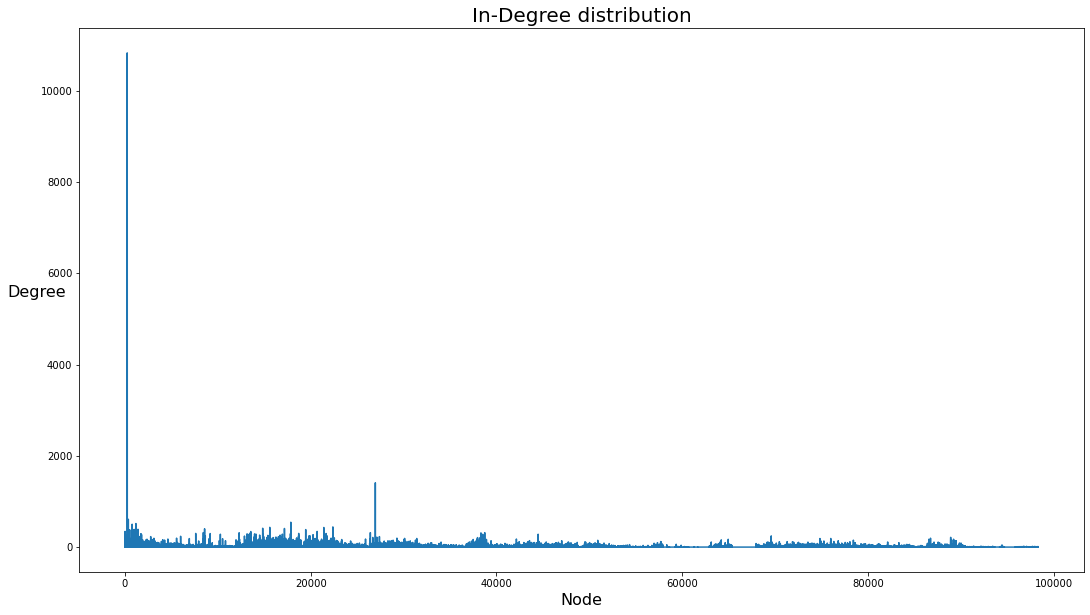

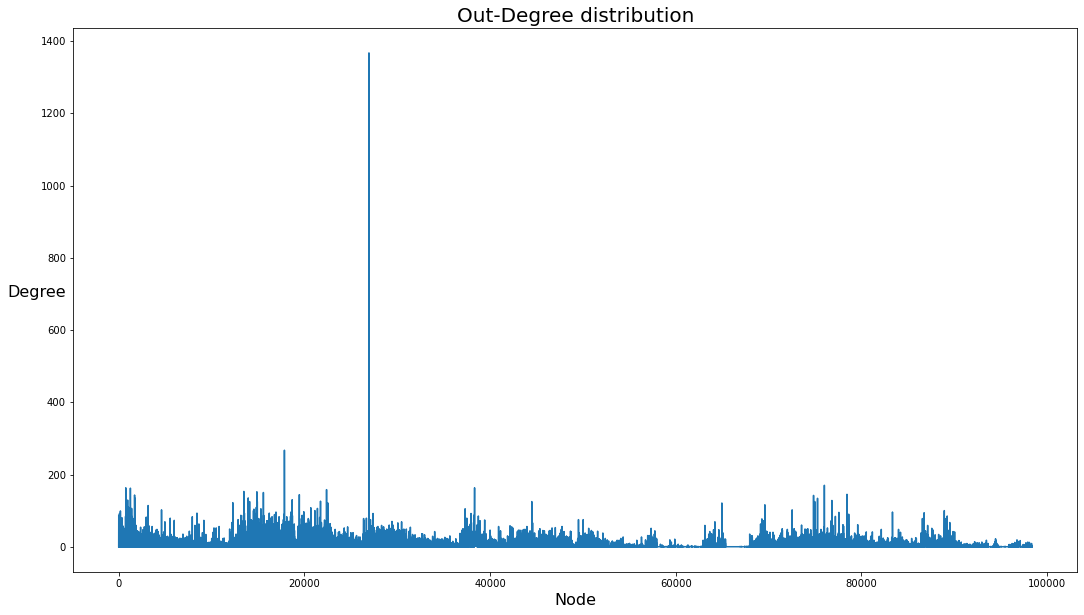

In [16]:
# degree distrubution
plt.figure(figsize=(18,10))
plt.title("In-Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(incoming_links.values()))

plt.figure(figsize=(18,10))
plt.title("Out-Degree distribution", fontsize=20)
plt.xlabel('Node', fontsize=16)
plt.ylabel('Degree', fontsize=16, rotation=360)
plt.plot(list(outgoing_links.values()))

## RQ2

The function __exploring__ take in input a page _v_ and a number of clcks _d_ and return a set of pages that user can reach in _d_ clicks from _v_.

In [17]:
# function to explore graph
def exploring(v, d):
    p = inverted_page_names[v]
    indices = set()
    support_exploring(p, d, indices)
    return { page_names[i] for i in indices }

# support function for returning values
def support_exploring(v, d, ret):
    # v: page
    # d: number of clicks
    # g: input graph
    # r: return value
    if d == 0:
        return 
    for n in graph.neighbors(v):
        ret.add(n)
        support_exploring(n, d-1, ret)

In the next cell there is a sample of function execution with inputs:
- page: 'This Way (Hana Pestle album)';
- number of clicks: 3.

And after that another one with inputs:
- page: "Marty O'Brien";
- number of clicks: 1.

In [21]:
exploring('This Way (Hana Pestle album)', 4)

{'Sigourney Weaver',
 'Days of Wrath',
 'Fulvio Cecere',
 'Till the Clouds Roll By',
 'Christine Lakin',
 'Lee Remick',
 'Chris Sivertson',
 "River's Edge",
 'Incendiary Blonde',
 'Roger Smith (actor)',
 'Fight Club (film)',
 'Makenzie Vega',
 'Emily Hart',
 'Michelle Pfeiffer',
 'Enemy Mine (film)',
 'Date Night',
 'David Winters (choreographer)',
 'Face/Off',
 'Ninotchka',
 'Kiss Me, Stupid',
 'Daredevil (film)',
 'Halle Berry',
 'Girl, Interrupted (film)',
 'The Specialist',
 'Steelyard Blues',
 'Catherine Keener',
 'Daniel Franzese',
 "One Flew Over the Cuckoo's Nest (film)",
 'Amber Valletta',
 'Chevy Chase',
 'The Cheap Detective',
 'A Slight Case of Murder',
 'Ice Age: Continental Drift',
 'Our Winning Season',
 'Sleepy Hollow (film)',
 'The Parent Trap III',
 'Beverley Mitchell',
 'Dead Awake',
 'Joan Crawford',
 'The Upside of Anger',
 'Tough Enough (film)',
 'Candleshoe',
 'Lohan Holiday',
 'The Missing',
 'Black Snake Moan (film)',
 'In Good Company (2004 film)',
 'Willy Won

In [19]:
exploring("Marty O'Brien", 1)

{'22nd Century Lifestyle',
 'A Rhyme & Reason',
 'Kelly Clarkson',
 'Lindsay Lohan',
 'Ma',
 'Marilyn Manson'}

# RQ-3

In [135]:
# Find the central page in a category

def central_article(c):
    # c: category
    v = None
    d = 0
    degree = dict(graph.degree)
    for node in categories[c]:
        try:
            if degree[node] >= d:
                v = node
                d = degree[node]
        except:
            pass
    return v

In [140]:
# find the shortest path between two pages

def shortest_path(v,t):
    # v is the source page
    # t is the target page
    the_list = []
    dist = 0
    the_list = list(graph.neighbors(v))
    if t in the_list:
        dist +=1
        return dist
    else:
        dist +=1 
        while t not in the_list:
            the_set = set()
            for node in the_list:
                x = list(graph.neighbors(node))
                for node in x:
                    the_set.add(node)
            the_list = list(the_set)
            dist +=1
        return dist

In [ ]:
# define the set for all reachable pages from v.

big_set = set()
the_list = list(graph.neighbors(v))
for node in the_list:
    big_set.add(node)

for i in tqdm(range(100)):
    the_set = set()
    for node in the_list:
        x = list(graph.neighbors(node))
        for node in x:
            the_set.add(node)
            big_set.add(node)
    the_list = list(the_set)

In [157]:
# define a category and find the most centered page

c = 'Main Belt asteroids'
v = central_article(c)

# we have decided to check our algorithm and functions with a few pages defined below.

p = [870337, 870376, 870777, 870801, 870882,871104, 871106, 871107, 871136, 871134,1782123, 870912, 65792, 870405, 871176,
 870801, 1000853, 597145, 870940, 870945, 64419, 64932, 871077, 871462, 1098535, 1450792, 873017, 65596, 1402448, 1365072,
 1103442, 65110, 871001, 26715, 871533, 873070, 871023, 65142, 1400478, 871073, 871077, 1762988, 871091, 1400936, 1409644,
 871022, 871023, 876143, 67697, 65142, 597145, 871581, 873118, 1400478, 1165404, 1067106, 1400936, 1028218, 602240, 1063041,
 338049, 1181827, 1063044, 1058957]

# we have add all pages from category c to make sure our algorithm returns correct result

for i in range(len(categories[c])):
    p.append(categories[c][i])

# now we can check whether a page is reachable from most centered page and find the shortest path for each page defined above.

print ('We can reach to the pages written below with the steps written next to them:')

for node in p:
    if node not in big_set:
        print(page_names[node], 'Not possible!')
    else:
        step = Shortest_Path(v,node)
        print (page_names[node] + ' with ' + str(step) + ' step(s)')

  0%|                                                                                         | 0/9906 [00:00<?, ?it/s]

We can reach to the pages written below with the steps written next to them:
1270 Datura with 1 step(s)
1459 Magnya with 1 step(s)
132524 APL with 1 step(s)
2685 Masursky with 1 step(s)
298 Baptistina with 1 step(s)
2867 teins with 1 step(s)
55 Pandora with 2 step(s)
64 Angelina with 2 step(s)
21 Lutetia with 2 step(s)
324 Bamberga with 2 step(s)
Augusta family with 2 step(s)
434 Hungaria with 1 step(s)
Morris Raphael Cohen with 3 step(s)
Petit-Prince (moon) with 3 step(s)
254 Augusta with 3 step(s)
2685 Masursky with 1 step(s)
7472 Kumakiri with 1 step(s)
G. Stanley Hall with 3 step(s)
12 Victoria with 3 step(s)
18 Melpomene with 3 step(s)
Francis Ellingwood Abbot with 3 step(s)
Hilary Putnam with 3 step(s)
22 Kalliope with 1 step(s)
790 Pretoria with 3 step(s)
Henry M. Sheffer with 3 step(s)
Phocaea family with 1 step(s)
Main-belt comet with 1 step(s)
Hartry Field with 4 step(s)
W. E. B. Du Bois with 4 step(s)
David M. Young, Jr. with 4 step(s)
Richard S. Varga with 4 step(s)
Saul Kr

  3%|█▉                                                                            | 248/9906 [00:00<00:19, 490.49it/s]

67085 Oppenheimer with 9 step(s)
67853 Iwamura Not possible!
6199 Yoshiokayayoi Not possible!
63068 Moraes Not possible!
63163 Jerusalem Not possible!
11600 Cipolla Not possible!
14143 Hadfield Not possible!
23833 Mowers Not possible!
14463 McCarter Not possible!
6233 Kimura Not possible!
13096 Tigris Not possible!
7801 Goretti Not possible!
17612 Whiteknight Not possible!
1040 Klumpkea Not possible!
2384 Schulhof Not possible!
66939 Franscini Not possible!
5127 Bruhns Not possible!
14917 Taco Not possible!
5934 Mats Not possible!
6218 Mizushima Not possible!
4812 Hakuhou Not possible!
5454 Kojiki Not possible!
5082 Nihonsyoki Not possible!
5017 Tenchi Not possible!
4929 Yamatai Not possible!
4072 Yayoi Not possible!
4890 Shikanosima Not possible!
5541 Seimei Not possible!
4963 Kanroku Not possible!
5466 Makibi Not possible!
4855 Tenpyou Not possible!
4272 Entsuji Not possible!
7991 Kaguyahime Not possible!
6846 Kansazan Not possible!
7627 Wakenokiyomaro Not possible!
7105 Yousyozan No

  5%|███▋                                                                          | 463/9906 [00:01<00:25, 367.99it/s]

26733 Nanavisitor with 10 step(s)
8379 Straczynski Not possible!
26715 South Dakota Not possible!
1353 Maartje Not possible!
1879 Broederstroom Not possible!
1686 De Sitter Not possible!
4359 Berlage Not possible!
1641 Tana Not possible!
1948 Kampala Not possible!
1376 Michelle Not possible!
1359 Prieska Not possible!
1356 Nyanza Not possible!
1360 Tarka Not possible!
4511 Rembrandt Not possible!
2677 Joan Not possible!
1394 Algoa Not possible!
1701 Okavango Not possible!
1243 Pamela Not possible!
1321 Majuba Not possible!
1324 Knysna Not possible!
1355 Magoeba Not possible!
1248 Jugurtha Not possible!
2025 Nortia Not possible!
(5452) 1937 NN Not possible!
1354 Botha Not possible!
1349 Bechuana Not possible!
1325 Inanda Not possible!
1319 Disa Not possible!
1320 Impala Not possible!
1326 Losaka Not possible!
1318 Nerina Not possible!
1949 Messina Not possible!
1431 Luanda Not possible!
1430 Somalia Not possible!
1428 Mombasa Not possible!
1323 Tugela Not possible!
1242 Zambesia Not pos

 11%|████████▍                                                                    | 1092/9906 [00:01<00:13, 636.11it/s]

 Not possible!
43724 Pechstein Not possible!
8661 Ratzinger Not possible!
55733 Lepsius Not possible!
55735 Magdeburg Not possible!
9322 Lindenau Not possible!
13086 Sauerbruch Not possible!
5039 Rosenkavalier Not possible!
12244 Werfel Not possible!
27846 Honegger Not possible!
3539 Weimar Not possible!
10323 Frazer Not possible!
10055 Silcher Not possible!
5063 Monteverdi Not possible!
4972 Pachelbel Not possible!
3954 Mendelssohn Not possible!
3338 Richter Not possible!
5157 Hindemith Not possible!
4246 Telemann Not possible!
85559 Villecroze Not possible!
30857 Parsec Not possible!
8161 Newman Not possible!
69286 von Liebig Not possible!
(6785) 1990 VA7 Not possible!
(6393) 1990 HM1 Not possible!
19992 Schnbein Not possible!
6640 Falorni Not possible!
65769 Mahalia Not possible!
9610 Vischer Not possible!
15294 Underwood Not possible!
43793 Mackey Not possible!
5382 McKay Not possible!
9179 Satchmo Not possible!
15723 Girraween Not possible!
55755 Blythe Not possible!
16513 Vasks N

 16%|████████████▎                                                               | 1603/9906 [00:01<00:08, 1023.34it/s]

7912 Lapovok Not possible!
19096 Leonfridman Not possible!
8064 Lisitsa Not possible!
5415 Lyanzuridi Not possible!
10264 Marov Not possible!
4935 Maslachkova Not possible!
5245 Maslyakov Not possible!
11785 Migaic Not possible!
5016 Migirenko Not possible!
4067 Mikhel'son Not possible!
19081 Mravinskij Not possible!
4986 Osipovia Not possible!
12670 Passargea Not possible!
5269 Paustovskij Not possible!
20963 Pisarenko Not possible!
4619 Polyakhova Not possible!
6467 Prilepina Not possible!
5932 Prutkov Not possible!
11257 Rodionta Not possible!
5360 Rozhdestvenskij Not possible!
7073 Rudbelia Not possible!
12674 Rybalka Not possible!
7075 Sadovnichij Not possible!
4189 Sayany Not possible!
7725 Sel'vinskij Not possible!
4618 Shakhovskoj Not possible!
4074 Sharkov Not possible!
5044 Shestaka Not possible!
4280 Simonenko Not possible!
6575 Slavov Not possible!
2580 Smilevskia Not possible!
13005 Stankonyukhov Not possible!
4813 Terebizh Not possible!
3238 Timresovia Not possible!
4653 

2261 Keeler with 9 step(s)
1006 Lagrangea Not possible!
Petit-Prince (moon) with 3 step(s)
1125 China Not possible!
3789 Zhongguo Not possible!
1714 Sy Not possible!
1400 Tirela Not possible!
2227 Otto Struve Not possible!
2182 Semirot Not possible!
2026 Cottrell Not possible!
2974 Holden Not possible!
2168 Swope Not possible!
2070 Humason Not possible!
1788 Kiess Not possible!
1822 Waterman Not possible!
1761 Edmondson Not possible!
1799 Koussevitzky Not possible!
1721 Wells Not possible!
1729 Beryl Not possible!
1827 Atkinson Not possible!
1741 Giclas Not possible!
1766 Slipher Not possible!
1764 Cogshall Not possible!
2007 McCuskey Not possible!
1996 Adams Not possible!
3371 Giacconi Not possible!
2488 Bryan Not possible!
2023 Asaph Not possible!


 21%|████████████████▎                                                            | 2097/9906 [00:03<00:15, 516.90it/s]

3428 Roberts with 10 step(s)
2086 Newell Not possible!
2334 Cuffey Not possible!
2160 Spitzer Not possible!
3070 Aitken Not possible!
3363 Bowen Not possible!
3654 AAS Not possible!
2996 Bowman Not possible!
1614 Goldschmidt Not possible!
1622 Chacornac Not possible!
1657 Roemera Not possible!
4040 Purcell Not possible!
6231 Hundertwasser Not possible!
2523 Ryba Not possible!
6285 Ingram Not possible!
6266 Letzel Not possible!
5122 Mucha Not possible!
7867 Burian Not possible!
5020 Asimov Not possible!
6398 Timhunter Not possible!
4886 Kojima Not possible!
4317 Garibaldi Not possible!
3256 Daguerre Not possible!
2766 Leeuwenhoek Not possible!
6077 Messner Not possible!
4927 O'Connell Not possible!
3149 Okudzhava Not possible!
5203 Pavarotti Not possible!
4674 Pauling Not possible!
5345 Boynton Not possible!
5047 Zanda Not possible!
5308 Hutchison Not possible!
4473 Sears Not possible!
4595 Prinz Not possible!
5309 MacPherson Not possible!
4691 Toyen Not possible!
4054 Turnov Not possib

 24%|██████████████████▎                                                          | 2353/9906 [00:03<00:11, 669.79it/s]


948 Jucunda Not possible!
968 Petunia Not possible!
600 Musa Not possible!
970 Primula Not possible!
999 Zachia Not possible!
716 Berkeley Not possible!
671 Carnegia Not possible!
744 Aguntina Not possible!
738 Alagasta Not possible!
925 Alphonsina Not possible!
998 Bodea Not possible!
678 Fredegundis Not possible!
518 Halawe Not possible!
923 Herluga Not possible!
919 Ilsebill Not possible!
926 Imhilde Not possible!
583 Klotilde Not possible!
869 Mellena Not possible!
942 Romilda Not possible!
579 Sidonia Not possible!
964 Subamara Not possible!
772 Tanete Not possible!
732 Tjilaki Not possible!
672 Astarte Not possible!
768 Struveana Not possible!
720 Bohlinia Not possible!
495 Eulalia Not possible!
547 Praxedis with 5 step(s)
795 Fini Not possible!
701 Oriola Not possible!
698 Ernestina Not possible!
714 Ulula Not possible!
709 Fringilla Not possible!
713 Luscinia Not possible!
706 Hirundo Not possible!
660 Crescentia Not possible!
695 Bella Not possible!
625 Xenia Not possible!
64

 26%|███████████████████▋                                                         | 2539/9906 [00:03<00:09, 811.67it/s]

2309 Mr. Spock with 8 step(s)
1621 Druzhba Not possible!
1224 Fantasia Not possible!
3044 Saltykov Not possible!
3072 Vilnius Not possible!
30564 Olomouc Not possible!
6223 Dahl Not possible!
12374 Rakhat Not possible!
5995 Saint-Aignan Not possible!
8371 Goven Not possible!
20017 Alixcatherine Not possible!
9930 Billburrows Not possible!
9922 Catcheller Not possible!
1221 Amor Not possible!
2249 Yamamoto Not possible!
3008 Nojiri Not possible!
1719 Jens Not possible!
5704 Schumacher Not possible!
2465 Wilson Not possible!
4002 Shinagawa Not possible!
4979 Otawara Not possible!
2022 West Not possible!
1005 Arago Not possible!
1669 Dagmar Not possible!
1720 Niels Not possible!
1123 Shapleya Not possible!
1561 Fricke Not possible!
1079 Mimosa Not possible!
1815 Beethoven Not possible!
2896 Preiss Not possible!
1782 Schneller Not possible!
1117 Reginita Not possible!
1086 Nata Not possible!
1062 Ljuba Not possible!
1065 Amundsenia Not possible!
1118 Hanskya Not possible!
1084 Tamariwa Not

 27%|█████████████████████                                                        | 2717/9906 [00:06<00:47, 150.04it/s]

9965 GNU with 11 step(s)
36446 Cinodapistoia Not possible!
27270 Guidotti Not possible!
3908 Nyx Not possible!
3271 Ul Not possible!
2911 Miahelena Not possible!
2631 Zhejiang Not possible!
1886 Lowell Not possible!
9916 Kibirev Not possible!
2606 Odessa Not possible!
98494 Marsupilami Not possible!
8256 Shenzhou Not possible!
1983 Bok Not possible!
3193 Elliot Not possible!
3174 Alcock Not possible!
3041 Webb Not possible!
2817 Perec Not possible!
2316 Jo-Ann Not possible!
3325 TARDIS Not possible!
3545 Gaffey Not possible!
2830 Greenwich Not possible!
2710 Veverka Not possible!
3115 Baily Not possible!
3857 Cellino Not possible!
2636 Lassell Not possible!
2527 Gregory Not possible!
5394 Jurgens Not possible!
3172 Hirst Not possible!
3131 Mason-Dixon Not possible!
3125 Hay Not possible!
3197 Weissman Not possible!
4239 Goodman Not possible!
2971 Mohr Not possible!
2601 Bologna Not possible!
2569 Madeline Not possible!
3452 Hawke Not possible!
2648 Owa Not possible!
7166 Kennedy Not po

 30%|███████████████████████▏                                                     | 2991/9906 [00:07<00:31, 218.89it/s]

9882 Stallman with 10 step(s)
6825 Irvine Not possible!
5701 Baltuck Not possible!
4612 Greenstein Not possible!
6629 Kurtz Not possible!
5054 Keil Not possible!
9988 Erictemplebell Not possible!
11665 Dirichlet Not possible!
8217 Dominikhaek Not possible!
1860 Barbarossa Not possible!
5162 Piemonte Not possible!
5498 Gustafsson Not possible!
5546 Salavat Not possible!
3320 Namba Not possible!
3607 Naniwa Not possible!
3319 Kibi Not possible!
(11436) 1969 QR Not possible!
4701 Milani Not possible!
3820 Sauval Not possible!
3922 Heather Not possible!
9517 Niehaisheng Not possible!
4299 WIYN Not possible!
5708 Melancholia Not possible!
2628 Kopal Not possible!
5055 Opekushin Not possible!
4124 Herriot Not possible!
3024 Hainan Not possible!
3187 Dalian Not possible!
2510 Shandong Not possible!
4408 Zlat Koruna Not possible!
4405 Otava Not possible!
8315 Bajin Not possible!
2152 Hannibal Not possible!
4577 Chikako Not possible!
9494 Donici Not possible!
2734 Haek Not possible!
1595 Tanga 

1536 Pielinen Not possible!
1549 Mikko Not possible!
1525 Savonlinna Not possible!
1757 Porvoo Not possible!
2690 Ristiina Not possible!
4181 Kivi Not possible!
9917 Keynes Not possible!
2791 Paradise Not possible!
4137 Crabtree Not possible!
7806 Umasslowell Not possible!
(6215) 1973 EK Not possible!
(7044) 1971 UK Not possible!
2901 Bagehot Not possible!
2115 Irakli Not possible!
6362 Tunis Not possible!
2596 Vainu Bappu Not possible!
2187 La Silla Not possible!
3933 Portugal Not possible!
2116 Mtskheta Not possible!
2935 Naerum Not possible!
2147 Kharadze Not possible!
2052 Tamriko Not possible!
2526 Alisary Not possible!
2117 Danmark Not possible!
2053 Nuki Not possible!
5890 Carlsberg Not possible!
3989 Odin Not possible!
3229 Solnhofen Not possible!
1434 Margot Not possible!
1347 Patria Not possible!
1202 Marina Not possible!
2237 Melnikov Not possible!
1603 Neva Not possible!
1671 Chaika Not possible!
1271 Isergina Not possible!
1783 Albitskij Not possible!
1725 CrAO Not possibl

 39%|█████████████████████████████▉                                               | 3850/9906 [00:10<00:20, 296.74it/s]

13123 Tyson with 13 step(s)
9070 Ensab Not possible!
13111 Papacosmas Not possible!
9083 Ramboehm Not possible!
11941 Archinal Not possible!
24779 Presque Isle Not possible!
10346 Triathlon Not possible!
22312 Kelly Not possible!
8021 Walter Not possible!
11911 Angel Not possible!
13057 Jorgensen Not possible!
30934 Bakerhansen Not possible!
18368 Flandrau Not possible!
22338 Janemojo Not possible!
13615 Manulis Not possible!
18434 Mikesandras Not possible!
24778 Nemsu Not possible!
8358 Rickblakley Not possible!
16669 Rionuevo Not possible!
16514 Stevelia Not possible!
5211 Stevenson Not possible!
5430 Luu Not possible!
5029 Ireland Not possible!
5325 Silver Not possible!
7756 Scientia Not possible!
6670 Wallach Not possible!
6401 Roentgen Not possible!
12227 Penney Not possible!
7750 McEwen Not possible!
9277 Togashi Not possible!
7549 Woodard Not possible!
17408 McAdams Not possible!
6087 Lupo Not possible!
7958 Leakey Not possible!
22294 Simmons Not possible!
16452 Goldfinger Not p

 45%|██████████████████████████████████▍                                          | 4429/9906 [00:10<00:10, 541.80it/s]


1928 Summa Not possible!
3689 Yeates Not possible!
1842 Hynek Not possible!
4965 Takeda Not possible!
2613 Plze Not possible!
2936 Nechvle Not possible!
4610 Kjov Not possible!
4801 Ohe Not possible!
4921 Volont Not possible!
5894 Tel Not possible!
9383 Montlimar Not possible!
6434 Jewitt Not possible!
3276 Porta Coeli Not possible!
4105 Tsia Not possible!
1664 Felix Not possible!
6808 Plantin Not possible!
1256 Normannia Not possible!
8329 Speckman Not possible!
2486 Metshovi Not possible!
3636 Pajdukov Not possible!
4624 Stefani Not possible!
2246 Bowell Not possible!
4201 Orosz Not possible!
9987 Peano Not possible!
25000 Astrometria Not possible!
8001 Ramsden Not possible!
8067 Helfenstein Not possible!
3142 Kilopi Not possible!
1244 Deira Not possible!
3534 Sax Not possible!
1261 Legia Not possible!
1711 Sandrine Not possible!
2545 Verbiest Not possible!
1286 Banachiewicza Not possible!
1281 Jeanne Not possible!
2231 Durrell Not possible!
1639 Bower Not possible!
2109 Dhotel Not 

 48%|████████████████████████████████████▉                                        | 4748/9906 [00:10<00:07, 721.47it/s]

 Not possible!
6522 Aci Not possible!
6645 Arcetri Not possible!
5774 Ratliff Not possible!
4770 Lane Not possible!
7824 Lynch Not possible!
5181 SURF Not possible!
6518 Vernon Not possible!
8270 Winslow Not possible!
5208 Royer Not possible!
12284 Pohl Not possible!
4969 Lawrence Not possible!
6445 Bellmore Not possible!
5905 Johnson Not possible!
7780 Maren Not possible!
7781 Townsend Not possible!
4629 Walford Not possible!
3680 Sasha Not possible!
4950 House Not possible!
5278 Polly Not possible!
8082 Haynes Not possible!
8378 Sweeney Not possible!
16589 Hastrup Not possible!
1014 Semphyra Not possible!
2491 Tvashtri Not possible!
4423 Golden Not possible!
4158 Santini Not possible!
3694 Sharon Not possible!
9829 Murillo Not possible!
8610 Goldhaber Not possible!
9509 Amfortas Not possible!
9510 Gurnemanz Not possible!
10985 Feast Not possible!
2923 Schuyler Not possible!
3598 Saucier Not possible!
10446 Siegbahn Not possible!
9140 Deni Not possible!
4168 Millan Not possible!
2381 

 53%|████████████████████████████████████████                                    | 5226/9906 [00:10<00:04, 1106.19it/s]

Not possible!
9232 Miretti Not possible!
16766 Righi Not possible!
21306 Marani Not possible!
42747 Fuser Not possible!
12035 Ruggieri Not possible!
16761 Hertz Not possible!
11121 Malpighi Not possible!
10200 Quadri Not possible!
29457 Marcopolo Not possible!
26917 Pianoro Not possible!
58573 Serpieri Not possible!
15381 Spadolini Not possible!
42748 Andrisani Not possible!
47038 Majoni Not possible!
44005 Migliardi Not possible!
17652 Nepoti Not possible!
10197 Senigalliesi Not possible!
79375 Valetti Not possible!
33376 Medi Not possible!
10207 Comeniana Not possible!
65657 Hube Not possible!
65698 Emmarochelle Not possible!
73703 Billings Not possible!
120361 Guido Not possible!
117430 Achosyx Not possible!
78434 Dyer Not possible!
100077 Tertzakian Not possible!
85168 Albertacentenary Not possible!
85121 Loehde Not possible!
54820 Svenders Not possible!
(24650) 1986 QM Not possible!
(24651) 1986 QU Not possible!
24277 Schoch Not possible!
24068 Simonsen Not possible!
24059 Halvers

 59%|████████████████████████████████████████████▉                               | 5854/9906 [00:10<00:02, 1593.92it/s]

 Not possible!
21649 Vardhana Not possible!
17163 Vasifedoseev Not possible!
21678 Lindner Not possible!
16119 Bronner Not possible!
16996 Dahir Not possible!
17000 Medvedev Not possible!
19612 Noordung Not possible!
19788 Hunker Not possible!
19461 Feingold Not possible!
19426 Leal Not possible!
19497 Pineda Not possible!
19419 Pinkham Not possible!
19438 Khaki Not possible!
19450 Sussman Not possible!
19589 Kirkland Not possible!
19598 Luttrell Not possible!
19518 Moulding Not possible!
19575 Feeny Not possible!
19531 Charton Not possible!
19533 Garrison Not possible!
19810 Partridge Not possible!
19603 Monier Not possible!
19614 Montelongo Not possible!
19656 Simpkins Not possible!
19664 Yancey Not possible!
19652 Saris Not possible!
20798 Verlinden Not possible!
17225 Alanschorn Not possible!
17240 Gletorrence Not possible!
17198 Gorjup Not possible!
17277 Jarrydlevine Not possible!
17220 Johnpenna Not possible!
20768 Langberg Not possible!
20782 Markcroce Not possible!
17197 Matja

 62%|██████████████████████████████████████████████▉                             | 6111/9906 [00:10<00:02, 1792.25it/s]


14157 Pamelasobey Not possible!
19523 Paolofrisi Not possible!
19456 Pimdouglas Not possible!
14678 Pinney Not possible!
18698 Racharles Not possible!
18664 Rafaelta Not possible!
18658 Rajdev Not possible!
14114 Randyray Not possible!
15945 Raymondavid Not possible!
19457 Robcastillo Not possible!
21799 Ciociaria Not possible!
13274 Roygross Not possible!
18855 Sarahgutman Not possible!
13403 Sarahmousa Not possible!
16035 Sasandford Not possible!
18946 Massar Not possible!
18110 HASI Not possible!
18997 Mizrahi Not possible!
18938 Zarabeth Not possible!
18964 Fairhurst Not possible!
18987 Irani Not possible!
18928 Pontremoli Not possible!
18984 Olathe Not possible!
18116 Prato Not possible!
18814 Ivanovsky Not possible!
18727 Peacock Not possible!
18699 Quigley Not possible!
18601 Zafar Not possible!
18123 Pavan Not possible!
18196 Rowberry Not possible!
18115 Rathbun Not possible!
18092 Reinhold Not possible!
18087 Yamanaka Not possible!
18948 Hinkle Not possible!
18974 Brungardt N

 69%|████████████████████████████████████████████████████▍                       | 6839/9906 [00:11<00:01, 1904.54it/s]

12561 Howard with 8 step(s)
12515 Suiseki Not possible!
13609 Lewicki Not possible!
13543 Butler Not possible!
13693 Bondar Not possible!
13633 Ivens Not possible!
13606 Bean Not possible!
13227 Poor Not possible!
14937 Thirsk Not possible!
14959 TRIUMF Not possible!
14438 MacLean Not possible!
14724 SNO Not possible!
10918 Kodaly Not possible!
4255 Spacewatch Not possible!
9548 Fortran Not possible!
8408 Strom Not possible!
10585 Wabi-Sabi Not possible!
8690 Swindle Not possible!
10861 Ciske Not possible!
10372 Moran Not possible!
12431 Webster Not possible!
11317 Hitoshi Not possible!
11098 Ginsberg Not possible!
11580 Bautzen Not possible!
11997 Fassel Not possible!
11998 Fermilab Not possible!
11184 Postma Not possible!
6748 Bratton Not possible!
16561 Rawls Not possible!
10639 Gleason Not possible!
12496 Ekholm Not possible!
7948 Whitaker Not possible!
9438 Satie Not possible!
10404 McCall Not possible!
12846 Fullerton Not possible!
12843 Ewers Not possible!
16626 Thumper Not poss

 77%|██████████████████████████████████████████████████████████▌                 | 7638/9906 [00:11<00:00, 2401.99it/s]


18556 Battiato Not possible!
14040 Andrejka Not possible!
43956 Elidoro Not possible!
43993 Mariola Not possible!
8106 Carpino Not possible!
6882 Sormano Not possible!
26887 Tokyogiants Not possible!
37044 Papymarcel Not possible!
4433 Goldstone Not possible!
11378 Dauria Not possible!
2493 Elmer Not possible!
30840 Jackalice Not possible!
9687 Uhlenbeck Not possible!
9491 Thooft Not possible!
10448 Schawlow Not possible!
19620 Auckland Not possible!
23122 Lorgat Not possible!
14988 Tryggvason Not possible!
10438 Ludolph Not possible!
27922 Mascheroni Not possible!
9349 Lucas Not possible!
14420 Massey Not possible!
5380 Sprigg Not possible!
4679 Sybil Not possible!
4704 Sheena Not possible!
8218 Hosty Not possible!
4710 Wade Not possible!
4678 Ninian Not possible!
6194 Denali Not possible!
2197 Shanghai Not possible!
8166 Buczynski Not possible!
14643 Morata Not possible!
1225 Ariane Not possible!
24010 Stovall Not possible!
7536 Fahrenheit Not possible!
9373 Hamra Not possible!
1776

 83%|██████████████████████████████████████████████████████████████▊             | 8181/9906 [00:11<00:00, 2880.37it/s]

 Not possible!
2547 Hubei Not possible!
2854 Rawson Not possible!
3746 Heyuan Not possible!
3556 Lixiaohua Not possible!
3051 Nantong Not possible!
2617 Jiangxi Not possible!
3509 Sanshui Not possible!
2185 Guangdong Not possible!
2743 Chengdu Not possible!
2719 Suzhou Not possible!
2752 Wu Chien-Shiung Not possible!
2503 Liaoning Not possible!
3812 Lidaksum Not possible!
5539 Limporyen Not possible!
3513 Quqinyue Not possible!
2085 Henan Not possible!
2753 Duncan Not possible!
4464 Vulcano Not possible!
2592 Hunan Not possible!
8126 Chanwainam Not possible!
30718 Records Not possible!
30444 Shemp Not possible!
30439 Moe Not possible!
30440 Larry Not possible!
3562 Ignatius Not possible!
5886 Rutger Not possible!
4789 Sprattia Not possible!
13674 Bourge Not possible!
65091 Saramagrin Not possible!
88961 Valpertile Not possible!
51406 Massimocalvani Not possible!
77136 Mendillo Not possible!
89664 Pignata Not possible!
89739 Rampazzi Not possible!
72543 Simonemarchi Not possible!
5762 W

 87%|█████████████████████████████████████████████████████████████████▉          | 8587/9906 [00:11<00:00, 3106.82it/s]

 Not possible!
9481 Mench Not possible!
6205 Menottigalli Not possible!
10972 Merbold Not possible!
16888 Michaelbarber Not possible!
18626 Michaelcarr Not possible!
20399 Michaelesser Not possible!
10375 Michiokuga Not possible!
13396 Midavaine Not possible!
17779 Migomueller Not possible!
23096 Mihika Not possible!
17060 Mikecombi Not possible!
23216 Mikehagler Not possible!
70995 Mikemorton Not possible!
68948 Mikeoates Not possible!
10789 Mikeread Not possible!
20392 Mikeshepard Not possible!
6441 Milenajesensk Not possible!
6789 Milkey Not possible!
6992 Minano-machi Not possible!
28242 Mingantu Not possible!
4202 Minitti Not possible!
8214 Mirellalilli Not possible!
8555 Mirimao Not possible!
7790 Miselli Not possible!
2460 Mitlincoln Not possible!
16731 Mitsumata Not possible!
5650 Mochihito-o Not possible!
8889 Mockturtle Not possible!
30917 Moehorgan Not possible!
11426 Molster Not possible!
10722 Monari Not possible!
21553 Monchicourt Not possible!
8421 Montanari Not possible

 94%|████████████████████████████████████████████████████████████████████████▌    | 9335/9906 [00:13<00:00, 835.41it/s]

29986 Shunsuke with 12 step(s)
16759 Furuyama Not possible!
8552 Hyoichi Not possible!
7905 Juzoitami Not possible!
27003 Katoizumi Not possible!
49440 Kenzotange Not possible!
39635 Kusatao Not possible!
47293 Masamitsu Not possible!
7438 Misakatouge Not possible!
14939 Norikura Not possible!
58707 Kyoshi Not possible!
13239 Kana Not possible!
20151 Utsunomiya Not possible!
13207 Tamagawa Not possible!
15370 Kanchi Not possible!
11115 Kariya Not possible!
7716 Ube Not possible!
10163 Onomichi Not possible!
7678 Onoda Not possible!
65775 Reikotosa Not possible!
29737 Norihiro Not possible!
10601 Hiwatashi Not possible!
58466 Santoka Not possible!
7788 Tsukuba Not possible!
22402 Goshi Not possible!
10609 Hirai Not possible!
7206 Shiki Not possible!
11612 Obu Not possible!
15415 Rika Not possible!
8306 Shoko Not possible!
6255 Kuma Not possible!
10850 Denso Not possible!
8720 Takamizawa Not possible!
24962 Kenjitoba Not possible!
31671 Masatoshi Not possible!
24981 Shigekimurakami Not p

 97%|█████████████████████████████████████████████████████████████████████████▌  | 9596/9906 [00:13<00:00, 1026.55it/s]

 Not possible!
6664 Tennyo Not possible!
7354 Ishiguro Not possible!
8043 Fukuhara Not possible!
9105 Matsumura Not possible!
8926 Abemasanao Not possible!
8047 Akikinoshita Not possible!
8232 Akiramizuno Not possible!
8707 Arakihiroshi Not possible!
12364 Asadagouryu Not possible!
9094 Butsuen Not possible!
11161 Daibosatsu Not possible!
7195 Danboice Not possible!
12802 Hagino Not possible!
7486 Hamabe Not possible!
6423 Harunasan Not possible!
8431 Haseda Not possible!
8301 Haseyuji Not possible!
7611 Hashitatsu Not possible!
11129 Hayachine Not possible!
6989 Hoshinosato Not possible!
7673 Inohara Not possible!
26169 Ishikawakiyoshi Not possible!
8582 Kazuhisa Not possible!
8302 Kazukin Not possible!
9099 Kenjitanabe Not possible!
11155 Kinpu Not possible!
20070 Koichiyuko Not possible!
6983 Komatsusakyo Not possible!
7901 Konnai Not possible!
11133 Kumotori Not possible!
8574 Makotoirie Not possible!
8403 Minorushimizu Not possible!
6995 Minoyama Not possible!
8303 Miyaji Not poss

100%|█████████████████████████████████████████████████████████████████████████████| 9906/9906 [00:13<00:00, 727.81it/s]

3487 Edgeworth Not possible!
29053 Muskau Not possible!
15964 Billgray Not possible!
24173 SLAS Not possible!
18876 Sooner Not possible!
1283 Komsomolia Not possible!
1330 Spiridonia Not possible!
1030 Vitja Not possible!
1022 Olympiada Not possible!
1028 Lydina Not possible!
1071 Brita Not possible!
7440 Zvist Not possible!
17764 Schatzman Not possible!
38203 Sanner Not possible!
11437 Cardalda Not possible!
3773 Smithsonian Not possible!
4733 ORO Not possible!
19410 Guisard Not possible!
20106 Morton Not possible!
81915 Hartwick Not possible!
29348 Criswick Not possible!
6426 Vansek Not possible!
27396 Shuji Not possible!
10099 Glazebrook Not possible!
18240 Mould Not possible!
8691 Etsuko Not possible!
73782 Yanagida Not possible!
10566 Zabadak Not possible!
6308 Ebisuzaki Not possible!
7575 Kimuraseiji Not possible!
6405 Komiyama Not possible!
12342 Kudohmichiko Not possible!
9190 Masako Not possible!
6612 Hachioji Not possible!
9844 Otani Not possible!
7421 Kusaka Not possible!
66

In [150]:
big_set = set()
the_list = list(graph.neighbors(v))
for node in the_list:
    big_set.add(node)

for i in tqdm(range(100)):
    the_set = set()
    for node in the_list:
        x = list(graph.neighbors(node))
        for node in x:
            the_set.add(node)
            big_set.add(node)
    the_list = list(the_set) 
big_set

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [02:03<00:00,  1.21it/s]


{786432,
 786433,
 786434,
 786435,
 786436,
 786437,
 786438,
 573136,
 786440,
 786439,
 786442,
 786443,
 573137,
 786444,
 786445,
 786446,
 786448,
 655377,
 786447,
 786449,
 786450,
 786453,
 786454,
 786455,
 786456,
 786457,
 786458,
 786459,
 786460,
 786461,
 786462,
 786463,
 655392,
 786464,
 786466,
 786467,
 786465,
 786468,
 786470,
 786471,
 786472,
 786473,
 786474,
 1048618,
 786476,
 786475,
 786478,
 786477,
 786480,
 786481,
 786482,
 786483,
 786484,
 786485,
 786486,
 786487,
 786488,
 573146,
 786489,
 786490,
 1048636,
 1048637,
 1048638,
 1048639,
 786491,
 786492,
 786493,
 786495,
 786496,
 786501,
 786494,
 786498,
 1048648,
 786499,
 786505,
 786507,
 786508,
 1048653,
 1048654,
 786509,
 786510,
 786513,
 1048658,
 786511,
 1048660,
 1179733,
 786517,
 786512,
 786514,
 786515,
 786516,
 655451,
 786518,
 655453,
 1048670,
 786519,
 786528,
 786520,
 1048674,
 1198392,
 786532,
 1048677,
 786525,
 786527,
 1048680,
 786537,
 786538,
 786536,
 786540,
 78

In [151]:
len(big_set)

64010

## RQ4

The function __double_cat_subg__ returns a subgraph with the nodes and the edges corrispondent with the nodes present in the two categories.

The function __my_double_cat_subg__ has an implementation from scratch of the function subgraph of networkx library.

The result of the two function is the same.

In [25]:
def double_cat_subg(c1, c2):
    # c1: category 1
    # c2: category 2
    cat_nodes = set(categories[c1]) | set(categories[c2]) # the set of all possible nodes
    cat_nodes = cat_nodes & set(graph.nodes) # clean the node
    return graph.subgraph(cat_nodes)

In [26]:
def my_double_cat_subg(c1, c2):
    # c1: category 1
    # c2: category 2
    cat_nodes = set(categories[c1]) | set(categories[c2]) # the set of all possible nodes
    cat_nodes = cat_nodes & set(graph.nodes) # clean the node
    sg = nx.DiGraph()
    sg.add_nodes_from((n, graph.nodes[n]) for n in cat_nodes)
    sg.add_edges_from((n, nbr, d) for n, nbrs in graph.adj.items() if n in cat_nodes\
                      for nbr, d in nbrs.items() if nbr in cat_nodes)
    return sg

The function below find the best path between two nodes _u_ and _v_.

In [27]:
# finds shortest path between 2 nodes of a graph using BFS
def bfs_shortest_path(u, v, g):
    # u: start node
    # v: goal node
    # g: graph
    
    # keep track of explored nodes
    explored = []
    # keep track of all the paths to be checked
    queue = [[u]]
 
    # return path if start is goal
    if u == v:
        return "Exception: u and v are the same node" # no path! the nodes are the same
 
    # keeps looping until all possible paths have been checked
    while queue:
        # pop the first path from the queue
        path = queue.pop(0)
        # get the last node from the path
        node = path[-1]
        if node not in explored:
            # go through all neighbour nodes, construct a new path and
            # push it into the queue
            for neighbour in g.neighbors(node):
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                # return path if neighbour is goal
                if neighbour == v:
                    return new_path
 
            # mark node as explored
            explored.append(node)
 
    # in case there's no path between the 2 nodes
    return "Not possible"

In the cell below there is an example of the previous two functions.

In [28]:
sg = my_double_cat_subg('Main Belt asteroids', 'People from Worcester')
print("The subgraph is composed by 'Main Belt asteroids' and 'People from Worcester' categories.")
print( "That is an example of shortest path returned with 96584 870882 such nodes -->", bfs_shortest_path(96584, 870882, sg))

The subgraph is composed by 'Main Belt asteroids' and 'People from Worcester' categories.


NetworkXError: The node 96584 is not in the digraph.

The function below find the lenght of the minimum set of hyperlinks one can remove to disconnect _u_ and _v_.

In [29]:
def min_cut_subg(c1, c2, u, v):
    # c1: category 1
    # c2: category 2
    # u: start node
    # v: goal node
    sg = my_double_cat_subg(c1, c2)
    count = 0
    loop = True
    n1 = inverted_page_names[u]
    n2 = inverted_page_names[v]
    while loop:
        path = bfs_shortest_path(n1, n2, sg)
        if type(path) is str:
            loop = False
        else:
            count += 1
            removing = [ (path[i-1], path[i] ) for i in range(1, len(path)) ]
            for edge in removing:
                sg.remove_edge(*edge)
    return count

An example of function excution on the categories and the nodes of the previous example.

In [30]:
c1 = 'Main Belt asteroids'
c2 = 'People from Worcester'
u = page_names[96584]
v = page_names[870882]

print("The lenght of minimum set of hyperlinks one can remove to disconnect u and v is", min_cut_subg(c1, c2, u, v))

NetworkXError: The node 96584 is not in the digraph.

In the next two cells there are two support function for the __min_cut_subg_set__.
It finds he minimum set of hyperlinks one can remove to disconnect the nodes _u_ and _v_.

In [31]:
def sublists(l):
    # l: input list
    
    # list to store all the sublists 
    sublist = [] 
    for i in range(len(l) + 1): 
        for j in range(i + 1, len(l) + 1): 
            sli = l[i:j]  # make a slice of the subarray 
            sublist.append(sli) #add it to the list of sublists
    # sort list in order with the len of sublist
    sublist.sort(key=len)
    return sublist 

In [32]:
def connected(u, v, g):
    # u: start node
    # v: goal node
    # g: graph
    
    # keep track of explored nodes
    explored = []
    # keep track of all the nodes to be checked
    queue = [u] 
    if u == v:
        return None # no connection! the nodes are the same
    # keeps looping until all possible paths have been checked
    while queue:
        node = queue.pop(0)
        if node not in explored:
            for neighbour in g.neighbors(node):
                queue.append(neighbour)
                # return path if neighbour is goal
                if neighbour == v:
                    return True # there is a path!
            # mark node as explored
            explored.append(node)
    # in case there's no path between the 2 nodes
    return False

In [33]:
def min_cut_subg_set(c1, c2, u, v):
    # c1: category 1
    # c2: category 2
    # u: start node
    # v: goal node
    
    sg = my_double_cat_subg(c1, c2) # set subgraph
    loop = True
    n1 = inverted_page_names[u]
    n2 = inverted_page_names[v]
    
    removed = [] # the lit of edges removed
    while loop:
        path = bfs_shortest_path(n1, n2, sg)
        if type(path) is not str:
            r = [ (path[i-1], path[i] ) for i in range(1, len(path)) ]
            removing = sublists(r)
            # check wich set of edges doing disconnection
            for edgelist in removing:
                g = nx.Graph(sg)
                for edge in edgelist:
                    g.remove_edge(*edge)
                if not connected(n1, n2, g):
                    removed += edgelist
                    # return the correct set of edges
                    return { (page_names[edge[0]], page_names[edge[1]]) for edge in set(removed) }
            # repeat loop with new graph    
            for edge in r:
                sg.remove_edge(*edge)
            removed += r
        else:
            loop = False
    return { (page_names[edge[0]], page_names[edge[1]]) for edge in set(removed) }

An example of execution.

In [34]:
c1 = 'Main Belt asteroids'
c2 = 'People from Worcester'
u = page_names[96584]
v = page_names[870882]

print("Below there is the set of hyperlinks could be removed to disconnect u and v.")
print(min_cut_subg_set(c1, c2, u, v))

Below there is the set of hyperlinks could be removed to disconnect u and v.


NetworkXError: The node 96584 is not in the digraph.

## RQ5

For this question we assume that *the set of shortest paths* is a set composed by the lengher of shortest path from each pair of nodes in the two categories.

In [60]:
# support function for search median in an ordered list
median = lambda l : int((l[len(l)//2] + l[~(len(l)//2)]) / 2)

# find shortestpath between two categories
def shortestpath(c1, c2):
    # c1: category 1
    # c2: category 2
    
    r = set()
    for n1 in categories[c1]:
        for n2 in categories[c2]:
            if n1 in graph.nodes and n2 in graph.nodes:
                path = bfs_shortest_path(n1, n2, graph)
                if type(path) is not str:
                    r.add(len(path))
    return r

In [80]:
def other_categories(c):
    # c: category
    
    all_cat = set(categories)
    all_cat.remove(c)
    all_cat = list(all_cat)
    # calculate shortestpath
    distances = list()
    for cat in tqdm(all_cat):
        sp = shortestpath(c, cat)
        print(cat)
        if len(sp) > 0:
            distances.append(median(sorted(list(sp))))
    all_cat = [x for _, x in sorted(zip(distances, all_cat))]
    return all_cat

In [ ]:
other_categories('Old Stoics')

  0%|          | 0/17358 [00:00<?, ?it/s]

Gauteng cricketers
African American members of the United States House of Representatives
International film festivals
Balao class submarines
Austrian Jews
The CW Television Network affiliates


MemoryError: Unable to allocate 72.1 GiB for an array with shape (98343, 98343) and data type float64

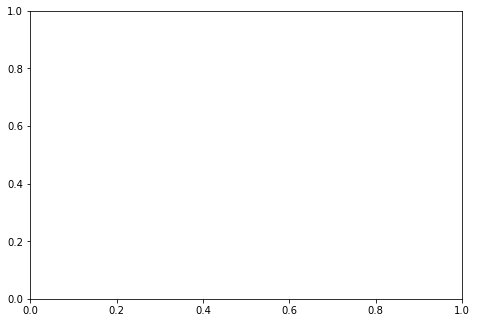

In [30]:
nx.draw(graph)